In [1]:
from datetime import datetime

import pymongo
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account

import matplotlib.pyplot as plt

In [2]:
DB_NAME = "sample_supplies"
COLLECTION = "sales"

In [3]:
client = pymongo.MongoClient("mongodb+srv://<user>:<password>@cluster0.wuajjwg.mongodb.net/?retryWrites=true&w=majority", server_api = pymongo.server_api.ServerApi('1'))

In [4]:
db = client[DB_NAME]

In [5]:
col = db[COLLECTION]

In [6]:
credentials = service_account.Credentials.from_service_account_file("./jsonprep.json", scopes = ["https://www.googleapis.com/auth/cloud-platform"])

In [7]:
client = bigquery.Client(credentials = credentials, project = credentials.project_id)

## Pregunta 1:

Cantidad de productos (tags) vendidos por meses del año

In [8]:
def build_first_object(obj):
    newObj = []
    
    for x in obj:
        for y in x["items"]:
            for z in y["tags"]:
                newObj.append({"month": x["saleDate"].month, "total":y["quantity"]*y["price"].to_decimal(), "tag": z})
    
    return newObj

In [9]:
def build_first2_object(obj):
    newObj = []
    
    for x in obj:
        for y in x["items"]:
            for z in y["tags"]:
                newObj.append({"month": x["saleDate"].month, "quantity":y["quantity"], "tag": z})
    
    return newObj

In [10]:
result1 = col.find({}, {"_id": 0, "items.name":1, "items.tags": 1, "items.quantity": 1, "items.price": 1, "saleDate": 1})
result1_ready = build_first_object(result1)

result12 = col.find({}, {"_id": 0, "items.name":1, "items.tags": 1, "items.quantity": 1, "saleDate": 1})
result12_ready = build_first2_object(result12)


In [11]:
df_1 = pd.json_normalize(result1_ready)
df_12 = pd.json_normalize(result12_ready)

In [12]:
df_1.head(5)

,month,total,tag
0,3,80.02,office
1,3,80.02,stationary
2,3,70.58,office
3,3,70.58,writing
4,3,70.58,school


In [13]:
df_12.head(5)

,month,quantity,tag
0,3,2,office
1,3,2,stationary
2,3,2,office
3,3,2,writing
4,3,2,school


In [14]:
df_1['month'] = pd.Categorical(df_1['month'])
df_1['tag'] = pd.Categorical(df_1['tag'])

df_12['month'] = pd.Categorical(df_12['month'])
df_12['tag'] = pd.Categorical(df_12['tag'])

In [15]:
df_1.dtypes

month    category
total      object
tag      category
dtype: object

In [16]:
df_1['tag'].unique()

['office', 'stationary', 'writing', 'school', 'travel', 'kids', 'general', 'organization', 'electronics']
Categories (9, object): ['electronics', 'general', 'kids', 'office', ..., 'school', 'stationary', 'travel', 'writing']

### Por precio

In [17]:
data_ready = df_1.groupby(['month', 'tag']).sum()

In [18]:
job_config = bigquery.LoadJobConfig(
    schema = [
        # Supported datatypes: https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types
        bigquery.SchemaField("month", bigquery.enums.SqlTypeNames.INT64),
        bigquery.SchemaField("tag", bigquery.enums.SqlTypeNames.STRING),
        bigquery.SchemaField("total", bigquery.enums.SqlTypeNames.INT64)
    ],
    # Drod and re-create table, if exist
    write_disposition = "WRITE_TRUNCATE",
)

In [19]:
BQ_TABLE_NAME = "dataprep.tags_per_month_price_mj"

In [20]:
job = client.load_table_from_dataframe(
    data_ready, BQ_TABLE_NAME, job_config = job_config
)

job.result()

LoadJob<project=javeriana-dataprep, location=us-central1, id=6f7676a1-bb9d-4db8-a0ec-b2b36955f5b8>

In [21]:
table = client.get_table(BQ_TABLE_NAME)

print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), BQ_TABLE_NAME))

Loaded 108 rows and 3 columns to dataprep.tags_per_month_price_mj


In [22]:
query = """SELECT * FROM `javeriana-dataprep.dataprep.tags_per_month_price_mj`"""

df1_bigQ = pd.read_gbq(query, credentials = credentials)

df1_bigQ['month'] = pd.Categorical(df1_bigQ['month'])
df1_bigQ['tag'] = pd.Categorical(df1_bigQ['tag'])

In [23]:
df1_bigQ = df1_bigQ.groupby(['month', 'tag']).sum()

<AxesSubplot:xlabel='month'>

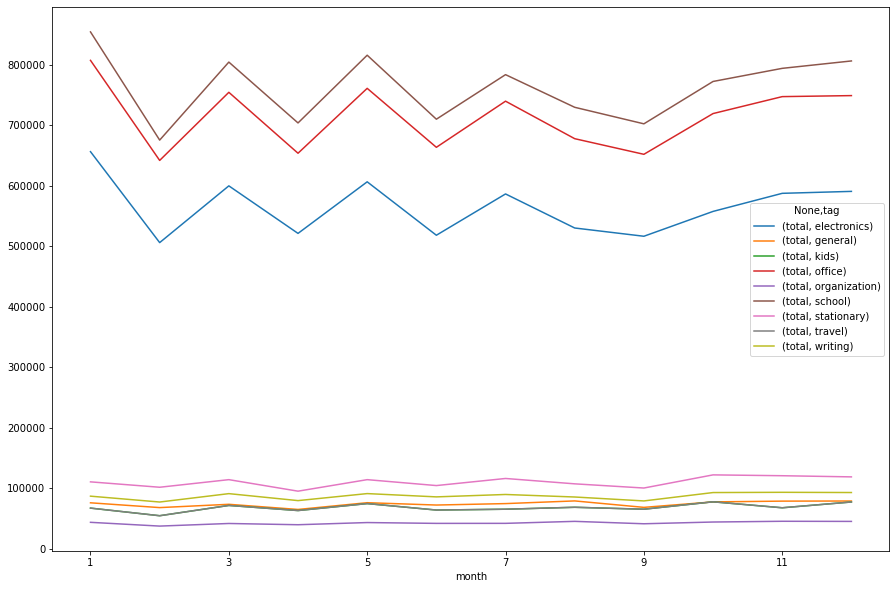

In [24]:
df1_bigQ.unstack().plot(figsize=(15,10))

### Por cantidad

In [25]:
data_ready12 = df_12.groupby(['month', 'tag']).sum()

In [26]:
job_config = bigquery.LoadJobConfig(
    schema = [
        # Supported datatypes: https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types
        bigquery.SchemaField("month", bigquery.enums.SqlTypeNames.INT64),
        bigquery.SchemaField("tag", bigquery.enums.SqlTypeNames.STRING),
        bigquery.SchemaField("quantity", bigquery.enums.SqlTypeNames.INT64)
    ],
    # Drod and re-create table, if exist
    write_disposition = "WRITE_TRUNCATE",
)

In [27]:
BQ_TABLE_NAME = "dataprep.tags_per_month_mj"

In [28]:
job = client.load_table_from_dataframe(
    data_ready12, BQ_TABLE_NAME, job_config = job_config
)

job.result()

LoadJob<project=javeriana-dataprep, location=us-central1, id=5aa96306-beae-4773-8b7a-613a8eceace9>

In [29]:
table = client.get_table(BQ_TABLE_NAME)

print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), BQ_TABLE_NAME))

Loaded 108 rows and 3 columns to dataprep.tags_per_month_mj


In [30]:
query = """SELECT * FROM `javeriana-dataprep.dataprep.tags_per_month_mj`"""

df12_bigQ = pd.read_gbq(query, credentials = credentials)

df12_bigQ['month'] = pd.Categorical(df12_bigQ['month'])
df12_bigQ['tag'] = pd.Categorical(df12_bigQ['tag'])

In [31]:
df12_bigQ = df12_bigQ.groupby(['month', 'tag']).sum()

<AxesSubplot:xlabel='month'>

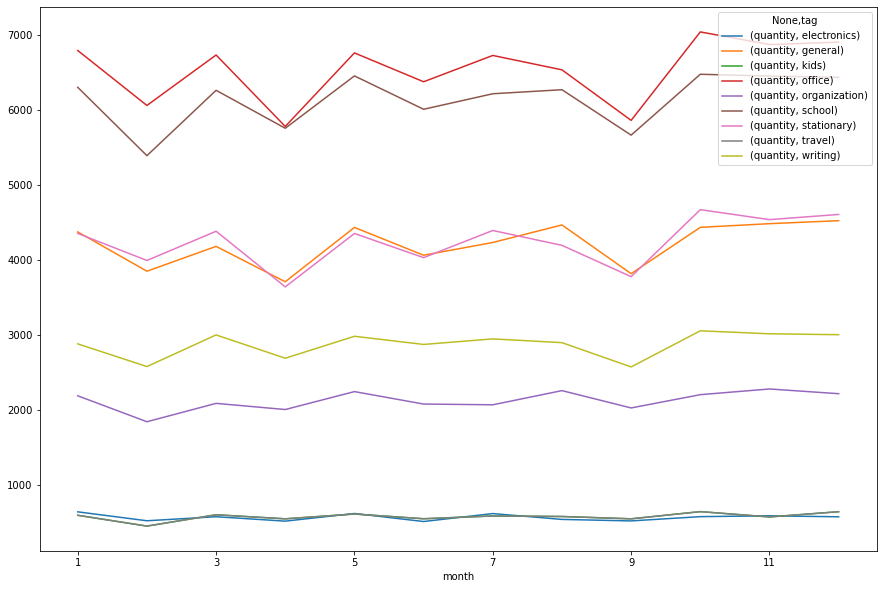

In [32]:
df12_bigQ.unstack().plot(figsize=(15,10))

## Pregunta 3:
Proporcion metodos de compras por grupos de edades

In [33]:
result3 = col.find({}, {"_id": 0, "customer.age":1, "purchaseMethod": 1})

In [34]:
df_3 = pd.json_normalize(result3).rename(columns={"customer.age":"age"})

In [35]:
df_3

,purchaseMethod,age
0,Online,42
1,Phone,50
2,In store,51
3,In store,45
4,In store,40
...,...,...
4995,In store,45
4996,In store,47
4997,In store,29
4998,Online,59


In [36]:
df_3['age'].max()


75

In [37]:
df_3['age'].min()

16

In [38]:
def build_third_object(x):
    if x>10 and x<=20:
        return "10-20"
    elif x>20 and x<=30:
        return "20-30"
    elif x>30 and x<=40:
        return "30-40"
    elif x>40 and x<=50:
        return "40-50"
    elif x>50 and x<=60:
        return "50-60"
    elif x>60 and x<=70:
        return "60-70"
    elif x>70 and x<=80:
        return "70-80"

In [39]:
df_3['group'] = df_3['age'].apply(build_third_object)
df_3.drop('age', inplace=True, axis=1)

In [40]:
df_3

,purchaseMethod,group
0,Online,40-50
1,Phone,40-50
2,In store,50-60
3,In store,40-50
4,In store,30-40
...,...,...
4995,In store,40-50
4996,In store,40-50
4997,In store,20-30
4998,Online,50-60


In [41]:
df_3['group'] = pd.Categorical(df_3['group'])
df_3['purchaseMethod'] = pd.Categorical(df_3['purchaseMethod'])

In [42]:
df_3

,purchaseMethod,group
0,Online,40-50
1,Phone,40-50
2,In store,50-60
3,In store,40-50
4,In store,30-40
...,...,...
4995,In store,40-50
4996,In store,40-50
4997,In store,20-30
4998,Online,50-60


### To bigQuery

In [43]:
job_config = bigquery.LoadJobConfig(
    schema = [
        # Supported datatypes: https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types
        bigquery.SchemaField("purchaseMethod", bigquery.enums.SqlTypeNames.STRING),
        bigquery.SchemaField("group", bigquery.enums.SqlTypeNames.STRING)
    ],
    # Drod and re-create table, if exist
    write_disposition = "WRITE_TRUNCATE",
)

In [44]:
BQ_TABLE_NAME = "dataprep.purchaseMethod_per_group_mj"

In [45]:
job = client.load_table_from_dataframe(
    df_3, BQ_TABLE_NAME, job_config = job_config
)

job.result()

LoadJob<project=javeriana-dataprep, location=us-central1, id=4d382bbb-c00e-4deb-ae55-4ad9dec5edae>

In [46]:
table = client.get_table(BQ_TABLE_NAME)

print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), BQ_TABLE_NAME))

Loaded 5000 rows and 2 columns to dataprep.purchaseMethod_per_group_mj


In [47]:
query = """SELECT * FROM `javeriana-dataprep.dataprep.purchaseMethod_per_group_mj`"""

df3_bigQ = pd.read_gbq(query, credentials = credentials)

df3_bigQ['purchaseMethod'] = pd.Categorical(df3_bigQ['purchaseMethod'])
df3_bigQ['group'] = pd.Categorical(df3_bigQ['group'])

In [48]:
data_3 = df3_bigQ.groupby(['group', 'purchaseMethod']).size()
data_ready3 = data_3.reset_index(name='counts')

data_ready3

,group,purchaseMethod,counts
0,10-20,In store,117
1,10-20,Online,75
2,10-20,Phone,29
3,20-30,In store,370
4,20-30,Online,196
5,20-30,Phone,94
6,30-40,In store,664
7,30-40,Online,390
8,30-40,Phone,144
9,40-50,In store,686


In [49]:
data_ready3.dtypes

group             category
purchaseMethod    category
counts               int64
dtype: object

In [50]:
data_ready3 = data_ready3.groupby(['group', 'purchaseMethod']).sum()

In [51]:
data_ready3

counts
group purchaseMethod        
10-20 In store           117
      Online              75
      Phone               29
20-30 In store           370
      Online             196
      Phone               94
30-40 In store           664
      Online             390
      Phone              144
40-50 In store           686
      Online             363
      Phone              146
50-60 In store           486
      Online             310
      Phone               91
60-70 In store           379
      Online             188
      Phone               70
70-80 In store           117
      Online              63
      Phone               22

<AxesSubplot:xlabel='group'>

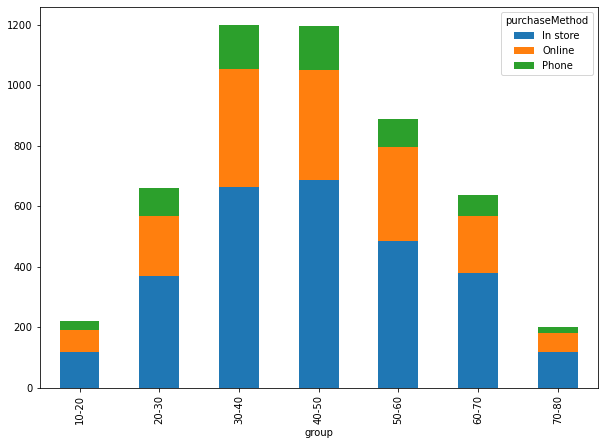

In [52]:
data_ready3.unstack().plot(kind='bar', y = 'counts', stacked=True, figsize=(10,7))

In [53]:
i = 0
suma = 0
Totals = []
for element in data_3:
    suma += element
    i+=1
    if i==3:
        Totals.append(suma)
        i=0
        suma = 0

In [54]:
Totals

[221, 660, 1198, 1195, 887, 637, 202]

In [55]:
norm = []
i = 0
j = 0
for element in data_3:
    norm.append(element/Totals[j])
    i += 1
    if i==3:
        i=0
        j+=1

In [56]:
data_ready3['norm'] = norm
data_ready3

counts      norm
group purchaseMethod                  
10-20 In store           117  0.529412
      Online              75  0.339367
      Phone               29  0.131222
20-30 In store           370  0.560606
      Online             196  0.296970
      Phone               94  0.142424
30-40 In store           664  0.554257
      Online             390  0.325543
      Phone              144  0.120200
40-50 In store           686  0.574059
      Online             363  0.303766
      Phone              146  0.122176
50-60 In store           486  0.547914
      Online             310  0.349493
      Phone               91  0.102593
60-70 In store           379  0.594976
      Online             188  0.295133
      Phone               70  0.109890
70-80 In store           117  0.579208
      Online              63  0.311881
      Phone               22  0.108911

<AxesSubplot:xlabel='group'>

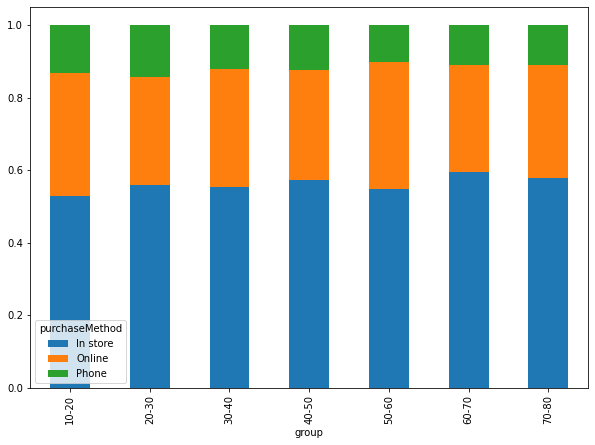

In [57]:
data_ready3.unstack().plot(kind='bar',y='norm',stacked=True, figsize=(10,7))

## Pregunta 3:
Cómo cambia el nivel de satisfacción de los clientes con respecto a la tienda donde realizaron la compra

In [58]:
result1 = col.find({}, {"_id": 0, "storeLocation":1, "customer.satisfaction": 1})

In [59]:
df = pd.json_normalize(result1)

In [60]:
df.head()

,storeLocation,customer.satisfaction
0,Denver,4
1,Seattle,5
2,Denver,5
3,Seattle,3
4,London,4


In [61]:
df.storeLocation.unique()

array(['Denver', 'Seattle', 'London', 'Austin', 'New York', 'San Diego'],
      dtype=object)

In [62]:
df['customer.satisfaction'].describe()

count    5000.000000
mean        3.793200
std         1.217346
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: customer.satisfaction, dtype: float64

In [63]:
df.rename(columns={"customer.satisfaction":"satisfaction"},inplace=True)

In [64]:
groupby = df.groupby(['storeLocation','satisfaction']).size()

In [65]:
i = 0
suma = 0
Totals = []
for element in groupby:
    suma += element
    i+=1
    if i==5:
        Totals.append(suma)
        i=0
        suma = 0

In [66]:
Totals

[676, 1549, 794, 501, 346, 1134]

In [67]:
norm = []
i = 0
j = 0
for element in groupby:
    norm.append(element/Totals[j])
    i += 1
    if i==5:
        i=0
        j+=1

In [68]:
g2 = groupby.reset_index(name='Count').groupby(['storeLocation','satisfaction']).sum()

In [69]:
g2['norm'] = norm

In [70]:
g2

Count      norm
storeLocation satisfaction                 
Austin        1                51  0.075444
              2                58  0.085799
              3               119  0.176036
              4               217  0.321006
              5               231  0.341716
Denver        1               129  0.083280
              2               107  0.069077
              3               255  0.164622
              4               512  0.330536
              5               546  0.352485
London        1                52  0.065491
              2                62  0.078086
              3               141  0.177582
              4               275  0.346348
              5               264  0.332494
New York      1                38  0.075848
              2                44  0.087824
              3                74  0.147705
              4               168  0.335329
              5               177  0.353293
San Diego     1                24  0.069364
              2                35  0.101156
              3                53  0.153179
              4               112  0.323699
              5               122  0.352601
Seattle       1                94  0.082892
              2                88  0.077601
              3               176  0.155203
              4               380  0.335097
              5               396  0.349206

In [71]:
job_config = bigquery.LoadJobConfig(
    schema = [
        # Supported datatypes: https://cloud.google.com/bigquery/docs/reference/standard-sql/data-types
        bigquery.SchemaField("storeLocation", bigquery.enums.SqlTypeNames.STRING),
        bigquery.SchemaField("satisfaction", bigquery.enums.SqlTypeNames.INT64),
        bigquery.SchemaField("Count", bigquery.enums.SqlTypeNames.INT64),
        bigquery.SchemaField("norm", bigquery.enums.SqlTypeNames.FLOAT64),
    ],
    # Drod and re-create table, if exist
    write_disposition = "WRITE_TRUNCATE",
)

In [72]:
BQ_TABLE_NAME = "dataprep.satisfactin_per_location_mj"

In [73]:
job = client.load_table_from_dataframe(
    g2, BQ_TABLE_NAME, job_config = job_config
)

job.result()

LoadJob<project=javeriana-dataprep, location=us-central1, id=6340b9c7-fb61-44ca-979d-e0452dbec9fa>

In [74]:
table = client.get_table(BQ_TABLE_NAME)

print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), BQ_TABLE_NAME))

Loaded 30 rows and 4 columns to dataprep.satisfactin_per_location_mj


In [75]:
query = """SELECT * FROM `javeriana-dataprep.dataprep.satisfactin_per_location_mj`"""

df_bigq = pd.read_gbq(query, credentials = credentials)

df_bigq['storeLocation'] = pd.Categorical(df_bigq['storeLocation'])
df_bigq['satisfaction'] = pd.Categorical(df_bigq['satisfaction'])

In [76]:
df_bigq

,storeLocation,satisfaction,Count,norm
0,Austin,1,51,0.075444
1,Denver,1,129,0.083280
2,London,1,52,0.065491
3,New York,1,38,0.075848
4,San Diego,1,24,0.069364
5,Seattle,1,94,0.082892
6,Austin,2,58,0.085799
7,Denver,2,107,0.069077
8,London,2,62,0.078086
9,New York,2,44,0.087824


In [77]:
groupby = df_bigq.groupby(['storeLocation','satisfaction']).sum()

<AxesSubplot:xlabel='storeLocation'>

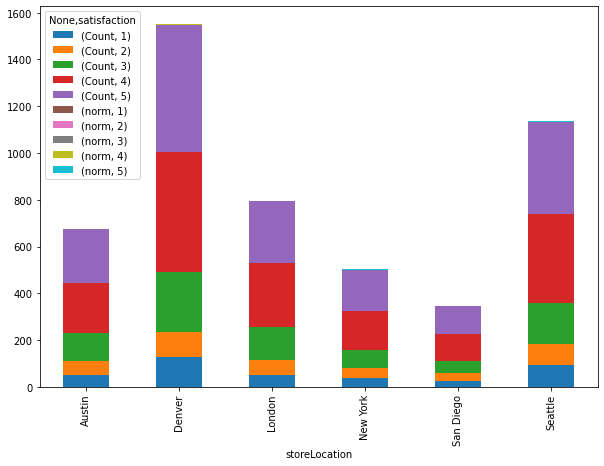

In [78]:
groupby.unstack().plot(kind='bar',stacked=True, figsize=(10,7))

<AxesSubplot:xlabel='storeLocation'>

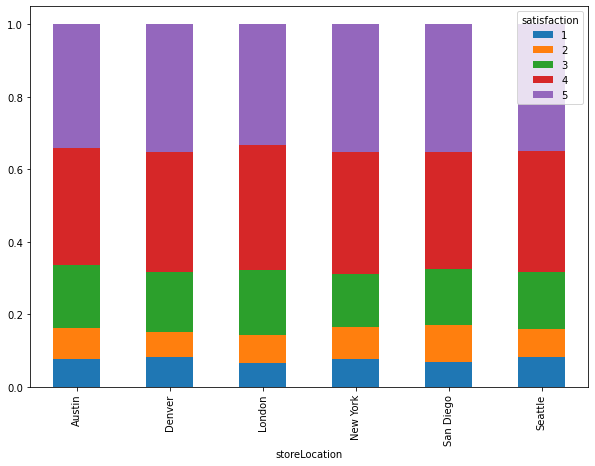

In [79]:
groupby.unstack().plot(kind='bar',y='norm',stacked=True, figsize=(10,7))